<a href="https://colab.research.google.com/github/robindong3/SD2I/blob/main/example/SD2I_experiment_microct2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##SD2I on experimental dataset
This script can be used to reproduce the Figure 8 (a) in the paper

This notebook contains the code for reconstructing experimental micro-CT image for NMC532 battery data. The image has the size of 779x779, and reconstructed from the sinogram with the size of 779x261

Download the miniconda and astra-toolbox

In [1]:
%env PYTHONPATH=

env: PYTHONPATH=


In [2]:
!which python
!python --version

/usr/local/bin/python
Python 3.10.10


In [3]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py310_23.3.1-0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.


--2023-05-13 13:00:50--  https://repo.continuum.io/miniconda/Miniconda3-py310_23.3.1-0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py310_23.3.1-0-Linux-x86_64.sh [following]
--2023-05-13 13:00:50--  https://repo.anaconda.com/miniconda/Miniconda3-py310_23.3.1-0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73134376 (70M) [application/x-sh]
Saving to: ‘Miniconda3-py310_23.3.1-0-Linux-x86_64.sh.3’

     0K .......... .......... .......... .......... ..........  0% 16.8M 4s
    50K .......... .........

In [4]:
!conda --version
!which conda

import sys
_ = (sys.path
        .append("/usr/local/lib/python3.10/site-packages"))
sys.path

conda 23.3.1
/usr/local/bin/conda


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.10/site-packages']

In [5]:
!conda install -c astra-toolbox/label/dev -y astra-toolbox

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox


The following packages will be UPDATED:

  certifi                         2022.12.7-py310h06a4308_0 --> 2023.5.7-py310h06a4308_0 




Preparing transaction: \ done
Verifying transaction: / done
Executing transaction: \ done


In [6]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install the SD2I packeage

In [7]:
! git clone https://github.com/robindong3/SD2I.git

fatal: destination path 'SD2I' already exists and is not an empty directory.


In [8]:
! cd SD2I && pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SD2I
  Preparing metadata (setup.py) ... done
  Attempting uninstall: sd2i
    Found existing installation: sd2i 2023.4
    Uninstalling sd2i-2023.4:
      Successfully uninstalled sd2i-2023.4
  Running setup.py develop for sd2i


In [9]:
! pip show sd2i
! pip show tensorflow_addons

Name: sd2i
Version: 2023.4
Summary: Single Digit to Image reconstruction tool
Home-page: https://github.com/robindong3/sd2i
Author: H. Dong
Author-email: robondong3@gmail.com
License: LICENSE.txt
Location: /content/SD2I
Editable project location: /content/SD2I
Requires: cached_property, h5py, matplotlib, numpy, scikit-image, scikit-learn, tqdm, xdesign
Required-by: 
Name: tensorflow-addons
Version: 0.20.0
Summary: TensorFlow Addons.
Home-page: UNKNOWN
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/site-packages
Requires: packaging, typeguard
Required-by: 


In [10]:
_ = (sys.path
        .append("/content/SD2I"))
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.10/site-packages',
 '/content/SD2I']

Import all packages

In [11]:
from sd2i.shapes.phantoms import SheppLogan
from sd2i.utils.plots import showim, cirmask
from sd2i.utils.convtomo import fbpvol, sinocentering

from sd2i.models.models_tf import GANrec, SD2I, Automap, Discriminator

from sd2i.utils.utils_tf import ssim_mae_loss, discriminator_loss
from sd2i.utils.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from sd2i.utils.utils_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle

import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import h5py
import tensorflow as tf

import matplotlib.pyplot as plt
import time
from skimage.draw import random_shapes
import astra
from numpy import deg2rad, arange

/usr/local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Check if Tensorflow will run on GPU


In [12]:
tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load the sinogram. We included all sinograms using in the paper.
Please choose from ['micro779_ch1', 'micro779_ch2', xrdct_ch1, xrdct_ch2, micro1559_ch1, micro1559_ch2]

In [13]:
#chose the dataset from ['micro779_ch1', 'micro779_ch2', xrdct_ch1, xrdct_ch2, micro1559_ch1, micro1559_ch2]
dataset_name = 'micro779_ch2'

fn = 'SD2I/sd2i/dataset/sinograms_used_in_paper.h5'

with h5py.File(fn, 'r') as f:
    print(f.keys())
    sino = np.array(f[dataset_name + '_angsamp'][:])
    sino_full = np.array(f[dataset_name][:])

print('sinogram shape before angular undersampling: ', sino_full.shape)
print('sinogram shape after angular undersampling: ', sino.shape)

<KeysViewHDF5 ['MnNaWSiO2', 'MnNaWSiO2_angsamp', 'POX', 'POX_angsamp', 'micro1559_ch1', 'micro1559_ch1_angsamp', 'micro1559_ch2', 'micro1559_ch2_angsamp', 'micro779_ch1', 'micro779_ch1_angsamp', 'micro779_ch2', 'micro779_ch2_angsamp', 'photocatalyst', 'photocatalyst_angsamp', 'xrdct_ch1', 'xrdct_ch1_angsamp', 'xrdct_ch2', 'xrdct_ch2_angsamp']>
sinogram shape before angular undersampling:  (1561, 779)
sinogram shape after angular undersampling:  (261, 779)


Choosing reconstruction method.

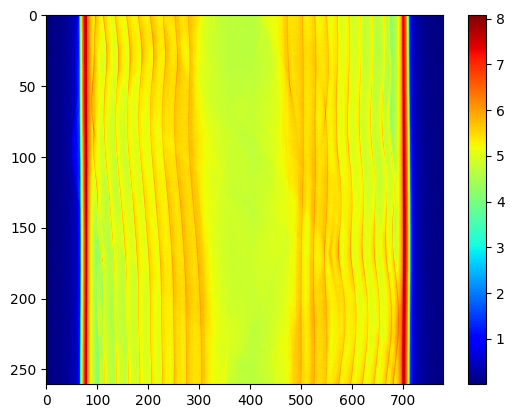

(1, 261, 779)


In [14]:
npix = sino.shape[1] # image size
npr = sino.shape[0] # number of projections

with_disc = False # Use discriminator or not

method = 'SD2Iup' # Choose method from 'SD2Iup', 'SD2I', 'GANrec', 'Automap'

factor = 8 # Used for SD2I methods

theta = np.radians(np.arange(0, 180, 180/sino_full.shape[0]))
if sino_full.shape[0]%npr == 0:
    theta = theta[::(sino_full.shape[0]//npr)]
else:
    theta = theta[::(sino_full.shape[0]//npr + 1)]

pattern_input = sino.reshape([1, npr, npix, 1])
showim(tf_tomo_squeeze(pattern_input), 2)

pattern_input = pattern_input[:,:,:,0]
print(pattern_input.shape)

Let's create the mask

In [15]:
mask = np.ones((npix, npix))
mask = cirmask(mask,0)

Calculate the reconstructed image using the filtered back projection algorithm

In [16]:
def relufunc(x):
    return (abs(x) + x) / 2

define the fbp algorithm

In [17]:
def astra_rec_single(sino, theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = None):
    
    '''
    2D ct reconstruction using the astra-toolbox
    1st dim in sinogram is translation steps, 2nd is projections
    Available astra-toolbox reconstruction algorithms:
    ART, SART, SIRT, CGLS, FBP
    SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA
    
    possible values for FilterType:
    none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
    triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
    blackman-nuttall, flat-top, kaiser, parzen    
    '''
    
    npr = sino.shape[1] # Number of projections
    
    if theta is None:
        if scanrange == '180':
            theta = deg2rad(arange(0, 180, 180/npr))
        elif scanrange == '360':
            theta = deg2rad(arange(0, 360, 360/npr))
            
    # Create a basic square volume geometry
    vol_geom = astra.create_vol_geom(sino.shape[0], sino.shape[0])
    # Create a parallel beam geometry with 180 angles between 0 and pi, and image.shape[0] detector pixels of width 1.
    proj_geom = astra.create_proj_geom('parallel', 1.0, int(1.0*sino.shape[0]), theta)
    # Create a sinogram using the GPU.
    proj_id = astra.create_projector('strip',proj_geom,vol_geom)
    sinogram_id = astra.data2d.create('-sino', proj_geom, sino.transpose())
    
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    
    cfg = astra.astra_dict(method)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id

    print('check')
    if method == 'FBP' or method == 'FBP_CUDA':
        cfg['option'] = { 'FilterType': filt }
    else:
        if nits is None:
            nits = 10 
    
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    start=time.time()

    if method == 'FBP' or method == 'FBP_CUDA':
        rec = astra.algorithm.run(alg_id)
    else:
        rec = astra.algorithm.run(alg_id, nits)
    
    # Get the result
    
    rec = astra.data2d.get(rec_id)
    
    print((time.time()-start))
        
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    
    return(rec)

(261, 779)
check
0.23707294464111328


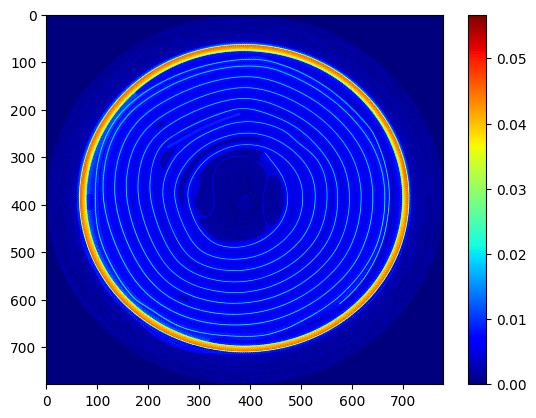

In [18]:
print(sino.shape)
fbp = astra_rec_single(np.array(sino).transpose(), theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = 250)
fbp[fbp<0] = 0
fbp *= mask[:,:]
showim(fbp, 3, clim=(0, np.max(fbp)))

Calculate the image without upsampling using the filtered back projection algorithm



check
0.05504035949707031


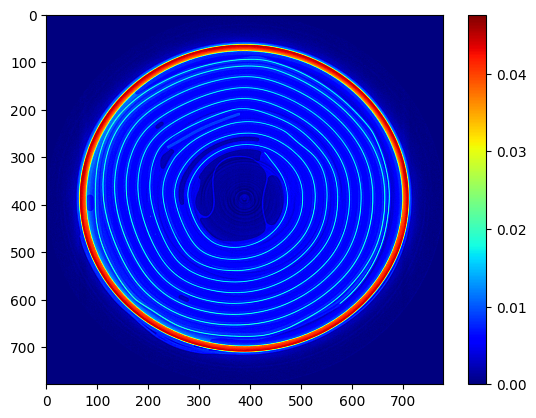

In [19]:
fbp_full = astra_rec_single(np.array(sino_full).transpose(), theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = 250)
fbp_full[fbp_full<0] = 0
fbp_full *= mask[:,:]
showim(fbp_full, 3, clim=(0, np.max(fbp_full)))

Calculate the image without upsampling using the CGLS algorithm


check
1.9948420524597168


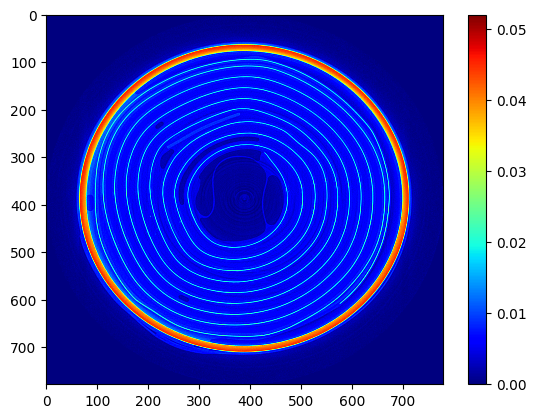

In [20]:
cgls_full = astra_rec_single(np.array(sino_full).transpose(), theta=None, scanrange = '180', method='CGLS_CUDA', filt='Ram-Lak', nits = 150)
cgls_full[cgls_full<0] = 0
cgls_full *= mask
showim(cgls_full, 3, clim=(0, np.max(cgls_full)))

Next we prepare the function for training the neural network




Training loop

In [21]:
if not with_disc:
    @tf.function 
    def train_step(input_number, dataset, mask):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
        
            print(generated_img.shape)
            generated_img = generated_img[0,:,:,0] * mask
            # generated_img = tf.nn.relu(generated_img)
            generated_img = tf.abs(generated_img)
            
            generated_img = tf.expand_dims(generated_img, 0, name=None)
            generated_img = tf.expand_dims(generated_img, 3, name=None)
            
            pattern_gen = tf_tomo_radon(generated_img, theta)
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            

            dataset = tf.transpose(dataset, [1, 2, 0])
            print(3)
            print(pattern_gen.shape)
            print(dataset.shape)

            matrix_loss = ssim_mae_loss(dataset, pattern_gen)

        grad_gen = tape.gradient(matrix_loss, generator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        return matrix_loss

else:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            print(generated_img.shape)
            generated_img = generated_img[0,:,:,0] * mask
            generated_img = tf.abs(generated_img)
            
            generated_img = tf.expand_dims(generated_img, 0, name=None)
            generated_img = tf.expand_dims(generated_img, 3, name=None)
            
            pattern_gen = tf_tomo_radon(generated_img, theta)
            
            real_output = discriminator(tf.expand_dims(dataset, -1))
            generated_output = discriminator(pattern_gen)
            
            pattern_gen = pattern_gen[0,:,:,0]
            
            pattern_gen = pattern_gen * mask
            
            pattern_gen = tf.expand_dims(pattern_gen, 2, name=None)
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(2)
            print(dataset.shape)
            print(pattern_gen.shape)
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                      labels=tf.ones_like(generated_output))) \
                       + ssim_mae_loss(dataset, pattern_gen)

            disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
            disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
            disc_loss = disc_loss_real+disc_loss_fake

        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        print(3)
        return gen_loss


Setup the model, optimizers and learning rate



In [22]:
if method == 'SD2Iup':
    generator = SD2I(npix, factor)
elif method == 'SD2I':
    generator = SD2I(npix, factor, upsample=False)
elif method == 'GANrec':
    generator = GANrec(npix, npr)
elif method == 'Automap':
    generator = Automap(npix, npr)
    
if with_disc:
    discriminator = Discriminator(npix, npr)
    disc_optimizer = tf.keras.optimizers.Adam(0.0005)
    
generator.summary()
gen_optimizer = tf.keras.optimizers.Adam(0.0005)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(300/100),
                            factor=0.5,
                            verbose=1, 
                            optim_lr=gen_optimizer.learning_rate, 
                            reduce_lin=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 304200)            19773000  
                                                                 
 reshape (Reshape)           (None, 195, 195, 8)       0     

In [23]:
max_point = np.max(sino)
print(max_point)
def ssim_mae_loss(y_true, y_pred):
    return((1-0.87)*tf.reduce_mean(tf.keras.losses.MAE(y_pred, y_true)) + 0.87*(1 - tf.reduce_mean(tf.image.ssim(y_pred, y_true, max_point))))


8.08687052335865


In [24]:
epochs = 8000
save_interval = 100

chemct_tf = tf.cast(pattern_input, 'float32')
mask = tf.cast(mask, 'float32')

if method == 'GANrec':
    bp = tf_tomo_bp(chemct_tf, theta)
    input_number = bp
elif method == 'Automap':
    input_number = chemct_tf
else:
    input_number = tf.cast(np.array([1]), 'float32')

start = time.time()
reduce_rl_plateau.on_train_begin()
kk = 1

for epoch in tqdm.tqdm_notebook(range(epochs)):

    loss = train_step(input_number, chemct_tf, mask)

    if epoch % save_interval == 0 and epoch != 0:

        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, (time.time() - start) / save_interval, loss))
        start = time.time()
        plt.close()

        reduce_rl_plateau.on_epoch_end(kk, loss)
        kk += 1


<ipython-input-24-4365274b9237>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(epochs)):


  0%|          | 0/8000 [00:00<?, ?it/s]

1
(1, 779, 779, 1)
3
(261, 779, 1)
(261, 779, 1)
1
(1, 779, 779, 1)
3
(261, 779, 1)
(261, 779, 1)
Time for epoch 1 to 100 is 0.43961806535720827 sec/it - gen_loss = 0.08771912008523941
Time for epoch 101 to 200 is 0.2578399419784546 sec/it - gen_loss = 0.0643499419093132
Time for epoch 201 to 300 is 0.2593000292778015 sec/it - gen_loss = 0.03009745478630066
Time for epoch 301 to 400 is 0.25601326942443847 sec/it - gen_loss = 0.03028923273086548
Time for epoch 401 to 500 is 0.2569034719467163 sec/it - gen_loss = 0.05547860264778137
Time for epoch 501 to 600 is 0.2582145833969116 sec/it - gen_loss = 0.03549432381987572

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Time for epoch 601 to 700 is 0.25733567237854005 sec/it - gen_loss = 0.014318419620394707
Time for epoch 701 to 800 is 0.25747438907623293 sec/it - gen_loss = 0.013941915705800056
Time for epoch 801 to 900 is 0.2580995941162109 sec/it - gen_loss = 0.013727936893701553
Time for epoch 901 to 100

Finally we plot the reconstructed image and compare it the filter back projected

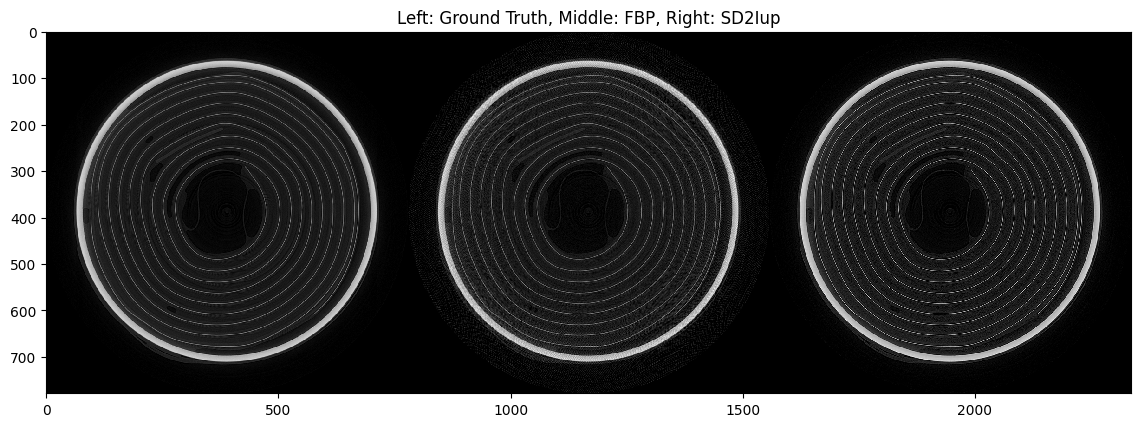

In [25]:
generated_img = generator(input_number)
generated_img = tf.abs(generated_img)
# generated_img = tf.nn.relu(generated_img)
generated_img = np.array(generated_img)
generated_img = generated_img[0,:,:,0] * mask
generated_img = relufunc(generated_img)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((fbp_full, fbp, generated_img[:,:]), axis=1), cmap='gray', interpolation = 'none')
# plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: {}'.format(method))
plt.show()


Do SIRT, SART, CGLS

In [26]:
img = [generated_img, cgls_full]
text = [str(method), 'cgls full']


method = ['FBP_CUDA', 'SART_CUDA', 'CGLS_CUDA', 'SIRT_CUDA']

for i in method:
    nits = 250
    rec = astra_rec_single(np.array(pattern_input[0,:,:]).transpose(), theta=None, scanrange = '180', method=i, filt='Ram-Lak', nits = nits)
    rec[rec<0] = 0

    img.append(rec)
    text.append(i)

check
0.011624813079833984
check
0.12127804756164551
check
0.6207823753356934
check
0.6082510948181152


In [27]:
full = tf.cast(cgls_full, tf.float32)
mask = np.array(mask)
full *= mask
maxpoint = np.max(full)

In [28]:
print(full.shape)
j = 0
for i in img:
    print(i.shape)
    i *=  mask[:,:]
    text_sub = text[j]
    j += 1
    im = np.reshape(i, (1, npix, npix,1))
    gt = np.reshape(full, (1, full.shape[0],  full.shape[1],1))
    
    gt = tf.cast(gt, tf.float32)
    
    i = tf.cast(i, tf.float32)
    im = tf.cast(im, tf.float32)
    mae = tf.reduce_mean(tf.keras.losses.MAE(i, full)).numpy()

    mse = tf.reduce_mean(tf.keras.losses.MSE(i, full)).numpy()

    psnr = tf.image.psnr(im, gt, maxpoint).numpy()

    ssim = tf.image.ssim(im, gt, maxpoint).numpy()
    print(text_sub)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('SSIM: ', ssim)
    print('PSNR: ', psnr)
    print('--------------------------------------')


(779, 779)
(779, 779)
SD2Iup
MAE:  0.0011459904
MSE:  3.2748096e-06
SSIM:  [0.7760438]
PSNR:  [29.167719]
--------------------------------------
(779, 779)
cgls full
MAE:  0.0
MSE:  0.0
SSIM:  [1.]
PSNR:  [inf]
--------------------------------------
(779, 779)
FBP_CUDA
MAE:  0.0017243953
MSE:  7.228109e-06
SSIM:  [0.6203971]
PSNR:  [25.729334]
--------------------------------------
(779, 779)
SART_CUDA
MAE:  0.0016334291
MSE:  9.044233e-06
SSIM:  [0.66776705]
PSNR:  [24.755861]
--------------------------------------
(779, 779)
CGLS_CUDA
MAE:  0.0015963631
MSE:  7.047532e-06
SSIM:  [0.66706586]
PSNR:  [25.839209]
--------------------------------------
(779, 779)
SIRT_CUDA
MAE:  0.0016423176
MSE:  1.0420651e-05
SSIM:  [0.67107147]
PSNR:  [24.140635]
--------------------------------------


0
1
2
3
4
5


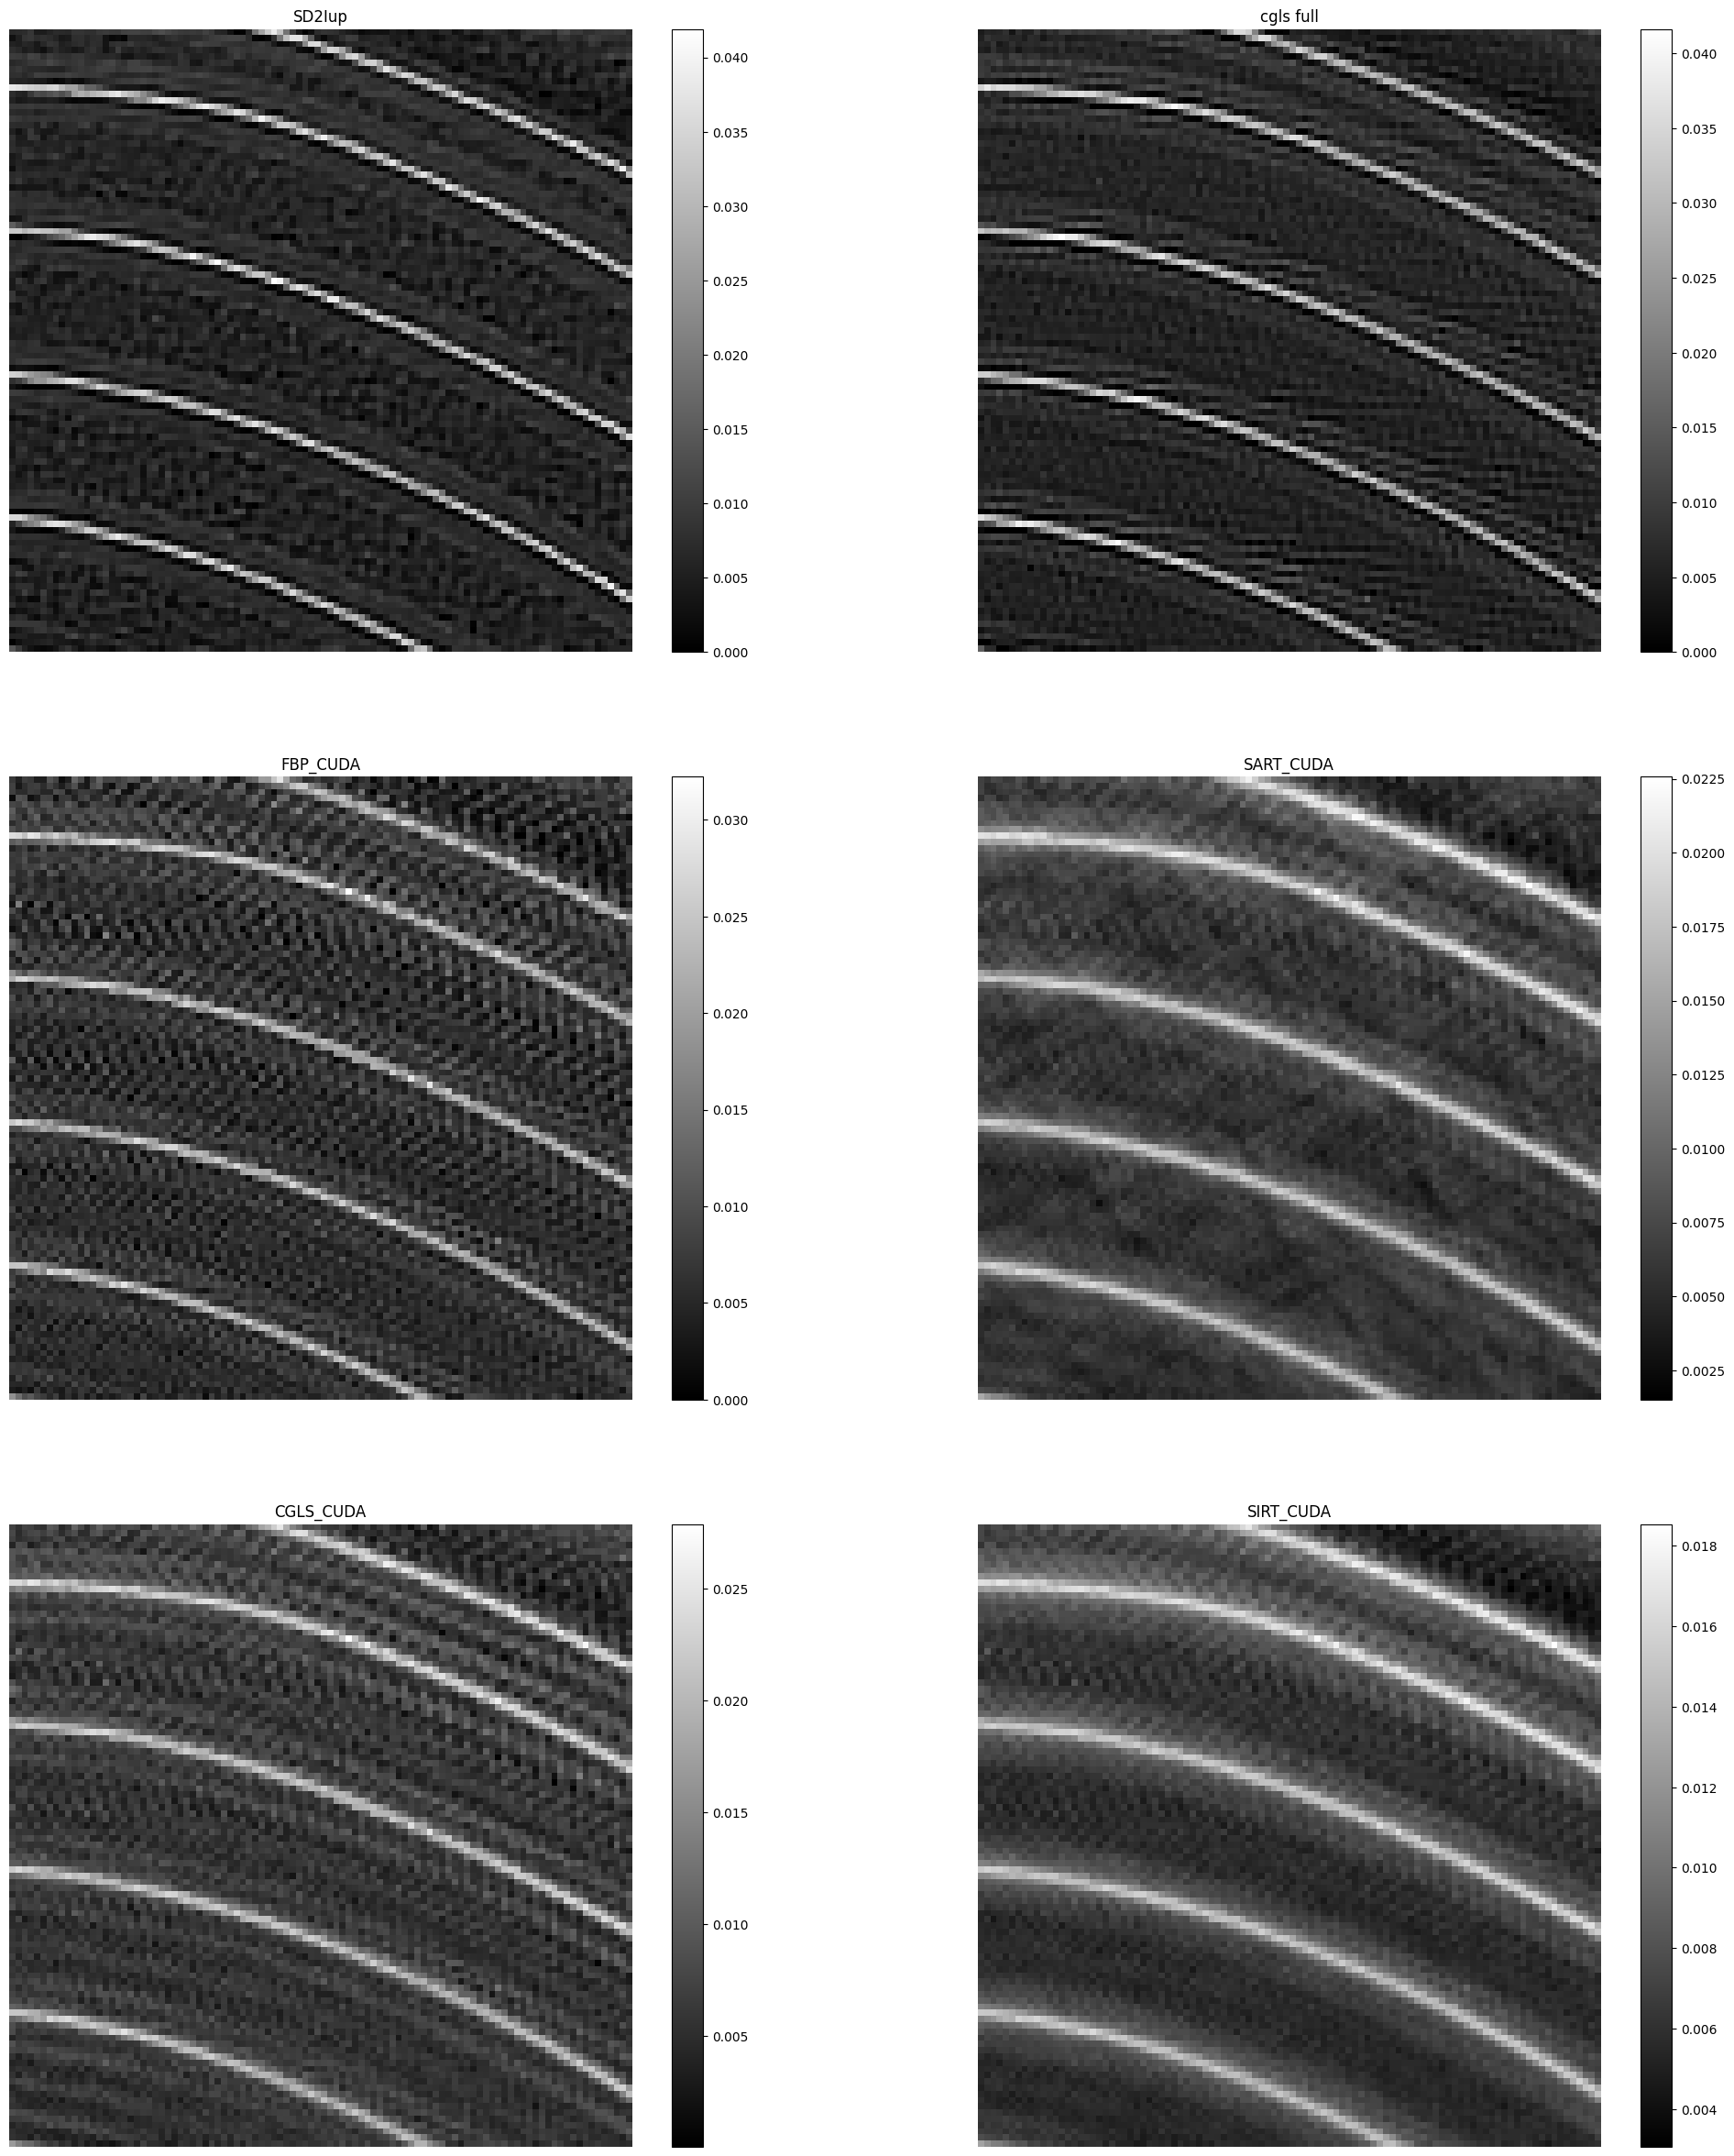

In [29]:
def plotfigs_imgs(imagelist, legendlist, rows=1, cols=5, figsize=(20,3), cl=True, cmap = 'gray'):
    
    '''
    Create a collage of images without xticks/yticks
    
    @author: Antony Vamvakeros and Thanasis Giokaris
    '''
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
    kk = 0
    for ii in range(axes.shape[0]):
        for jj in range(axes.shape[1]):
        
            print(kk)
            
            if kk < len(imagelist):
                # if kk != len(imagelist) - 1:
                if 1 == 1:

                    # i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                
                    i = axes[ii,jj].imshow(imagelist[kk][100:200,400:500], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                    axes[ii,jj].clim(0,100)

                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    
                    kk = kk + 1
                else:
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                
                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    

                    kk = kk + 1
    # fig.colorbar()
#     fig.savefig(folder + 'XRDCT_ch{}.png'.format(ch)).
plotfigs_imgs(img, text, rows=3, cols=2, figsize=(25,30), cl=True)
